In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score, classification_report
import optuna # Import Optuna
import logging # Optional: for cleaner Optuna logs

c:\Users\HP\Documents\college\semester-4\CAK2HAB3-dasar-kecerdasan-artifisial\project\fuzzy-system\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("--- Libraries Imported ---")
# Optional: Silence Optuna's default INFO logging if it's too verbose during many trials
optuna.logging.set_verbosity(optuna.logging.WARNING)

--- Libraries Imported ---


In [9]:
try:
    bmi_df_original = pd.read_csv('./data/bodyfat.csv')
    bmi_df = bmi_df_original.copy()
    columns_to_drop = ['Original', 'Neck', 'Forearm', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Wrist']
    columns_to_drop_existing = [col for col in columns_to_drop if col in bmi_df.columns]
    bmi_df.drop(columns=columns_to_drop_existing, inplace=True)
    numeric_columns = ['BodyFat', 'Age', 'Weight', 'Height']
    for column in numeric_columns:
        if column in bmi_df.columns:
            Q1 = bmi_df[column].quantile(0.25); Q3 = bmi_df[column].quantile(0.75); IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR; upper_bound = Q3 + 1.5 * IQR
            bmi_df = bmi_df[(bmi_df[column] >= lower_bound) & (bmi_df[column] <= upper_bound)]
    bmi_df = bmi_df[~((bmi_df['Sex'] == 'M') & (bmi_df['BodyFat'] < 2))]
    bmi_df = bmi_df[~((bmi_df['Sex'] == 'F') & (bmi_df['BodyFat'] < 10))]
    bmi_df = bmi_df[(bmi_df['Age'] >= 19) & (bmi_df['Age'] <= 65)]
    bmi_df['BMI'] = bmi_df['Weight'] / (bmi_df['Height'] ** 2)
    def categorize_bmi(bmi):
        if bmi < 18.5: return 'Underweight'
        elif 18.5 <= bmi < 24.9: return 'Normal'
        elif 24.9 <= bmi < 29.9: return 'Overweight'
        else: return 'Obese'
    bmi_df['BMI_Category'] = bmi_df['BMI'].apply(categorize_bmi)
    def categorize_body_fat_gendered(row):
        fat = row['BodyFat']; gender = row['Sex']
        if gender == 'M':
            if fat < 6:
                return 'Essential_Low'
            elif fat < 14:
                return 'Athletes'
            elif fat < 18:
                return 'Fitness'
            elif fat < 25:
                return 'Average'
            else:
                return 'Obese'
        else:
            if fat < 14:
                return 'Essential_Low'
            elif fat < 21:
                return 'Athletes'
            elif fat < 25:
                return 'Fitness'
            elif fat < 32:
                return 'Average'
            else:
                return 'Obese'
    bmi_df['BodyFat_Category'] = bmi_df.apply(categorize_body_fat_gendered, axis=1)
    print(f"Dataframe shape after initial prep: {bmi_df.shape}")
    if bmi_df.empty:
        raise ValueError("DataFrame is empty after pre-processing. Check your data or cleaning steps.")
except Exception as e:
    print(f"Error during data loading/preprocessing: {e}")
    # Fallback to a small dummy df for script structure testing if needed
    # bmi_df = pd.DataFrame(...)
    raise # Re-raise to stop if data isn't right

Dataframe shape after initial prep: (394, 8)


In [10]:
def get_sedentary_calories_v2(age, sex):
    sex = sex.lower()
    if 19 <= age <= 30: return 2000 if sex == 'f' else 2400
    elif 31 <= age <= 50: return 1800 if sex == 'f' else 2200
    elif 51 <= age <= 65: return 1600 if sex == 'f' else 2000
    else: return 1600 if sex == 'f' else 2000
def synthetic_calories_v2(row):
    sedentary_cals = get_sedentary_calories_v2(row['Age'], row['Sex'])
    bmi_cat = row['BMI_Category']; bf_cat = row['BodyFat_Category']
    target_cals = sedentary_cals * np.random.choice([1.0, 1.2, 1.4])
    if bmi_cat == 'Underweight' or bf_cat == 'Essential_Low': target_cals += np.random.randint(250, 500)
    elif bmi_cat == 'Obese' or bf_cat == 'Obese': target_cals -= np.random.randint(300, 600)
    elif bmi_cat == 'Overweight' or bf_cat in ['Average', 'Obese']: target_cals -= np.random.randint(150, 350)
    min_cal = 1200 if row['Sex'].lower() == 'f' else 1500
    target_cals = max(target_cals, min_cal)
    return int(round(target_cals / 50) * 50)
def get_protein_rda_g_v2(age, sex):
    sex = sex.lower()
    if 19 <= age <= 65: return 46 if sex == 'f' else 56
    else: return 46 if sex == 'f' else 56
def synthetic_protein_target_v2(row):
    rda = get_protein_rda_g_v2(row['Age'], row['Sex']); weight_kg = row['Weight']
    bmi_cat = row['BMI_Category']; calories = row['Calories']
    sedentary_calories = get_sedentary_calories_v2(row['Age'], row['Sex'])
    if bmi_cat == 'Underweight': g_per_kg = np.random.uniform(1.4, 1.8)
    elif bmi_cat == 'Obese': g_per_kg = np.random.uniform(1.2, 1.6)
    elif bmi_cat == 'Overweight': g_per_kg = np.random.uniform(1.0, 1.5)
    else:
        if calories > sedentary_calories * 1.3: g_per_kg = np.random.uniform(1.2, 1.6)
        elif calories > sedentary_calories * 1.1: g_per_kg = np.random.uniform(1.0, 1.3)
        else: g_per_kg = np.random.uniform(0.8, 1.1)
    target_protein = max(rda, g_per_kg * weight_kg) + np.random.uniform(-7, 7)
    return round(np.clip(target_protein, 40, 220), 1)


In [11]:
bmi_df['Calories'] = bmi_df.apply(synthetic_calories_v2, axis=1)
bmi_df['Protein'] = bmi_df.apply(synthetic_protein_target_v2, axis=1)
print("\n--- Synthetic Calories and Protein (V2) Generated ---")
print(bmi_df[['Calories', 'Protein']].describe())



--- Synthetic Calories and Protein (V2) Generated ---
          Calories     Protein
count   394.000000  394.000000
mean   2414.340102   86.784264
std     435.646045   24.597726
min    1450.000000   42.100000
25%    2000.000000   70.200000
50%    2400.000000   82.450000
75%    2787.500000  101.275000
max    3700.000000  177.500000


In [13]:
def bmi_mf_underweight(bmi):
    if bmi <= 18.5:
        return 1.0
    elif 18.5 < bmi <= 20.5:
        return (20.5 - bmi) / (20.5 - 18.5)
    else:
        return 0.0

def bmi_mf_normal(bmi):
    if 17.5 <= bmi < 18.5:
        return (bmi - 17.5) / (18.5 - 17.5)
    elif 18.5 <= bmi < 24.9:
        return 1.0
    elif 24.9 <= bmi < 26.5:
        return (26.5 - bmi) / (26.5 - 24.9)
    else:
        return 0.0

def bmi_mf_overweight(bmi):
    if 24.0 <= bmi < 24.9:
        return (bmi - 24.0) / (24.9 - 24.0)
    elif 24.9 <= bmi < 29.9:
        return 1.0
    elif 29.9 <= bmi < 31.5:
        return (31.5 - bmi) / (31.5 - 29.9)
    else:
        return 0.0

def bmi_mf_obese(bmi):
    if 29.0 <= bmi < 29.9:
        return (bmi - 29.0) / (29.9 - 29.0)
    elif bmi >= 29.9:
        return 1.0
    else:
        return 0.0

def bfm_essential_low(bf):
    if bf <= 3:
        return 1.0
    elif 3 < bf <= 7:
        return (7 - bf) / (7 - 3)
    else:
        return 0.0

def bfm_athletes(bf):
    if 5 < bf <= 9:
        return (bf - 5) / (9 - 5)
    elif 9 < bf <= 13:
        return 1.0
    elif 13 < bf <= 15:
        return (15 - bf) / (15 - 13)
    else:
        return 0.0

def bfm_fitness(bf):
    if 13 <= bf < 15:
        return (bf - 13) / (15 - 13)
    elif 15 <= bf < 18:
        return 1.0
    elif 18 <= bf < 20:
        return (20 - bf) / (20 - 18)
    else:
        return 0.0

def bfm_average(bf):
    if 18 <= bf < 21:
        return (bf - 18) / (21 - 18)
    elif 21 <= bf < 25:
        return 1.0
    elif 25 <= bf < 27:
        return (27 - bf) / (27 - 25)
    else:
        return 0.0

def bfm_obese(bf):
    if bf < 24:
        return 0.0
    elif 24 <= bf < 27:
        return (bf - 24) / (27 - 24)
    else:
        return 1.0

def bfw_essential_low(bf):
    if bf <= 11:
        return 1.0
    elif 11 < bf <= 15:
        return (15 - bf) / (15 - 11)
    else:
        return 0.0

def bfw_athletes(bf):
    if 13 < bf <= 17:
        return (bf - 13) / (17 - 13)
    elif 17 < bf <= 20:
        return 1.0
    elif 20 < bf <= 22:
        return (22 - bf) / (22 - 20)
    else:
        return 0.0

def bfw_fitness(bf):
    if 20 <= bf < 22:
        return (bf - 20) / (22 - 20)
    elif 22 <= bf < 25:
        return 1.0
    elif 25 <= bf < 27:
        return (27 - bf) / (27 - 25)
    else:
        return 0.0

def bfw_average(bf):
    if 25 <= bf < 28:
        return (bf - 25) / (28 - 25)
    elif 28 <= bf < 32:
        return 1.0
    elif 32 <= bf < 34:
        return (34 - bf) / (34 - 32)
    else:
        return 0.0

def bfw_obese(bf):
    if bf < 31:
        return 0.0
    elif 31 <= bf < 34:
        return (bf - 31) / (34 - 31)
    else:
        return 1.0

In [14]:
bmi_terms = {'Underweight': bmi_mf_underweight, 'Normal': bmi_mf_normal, 'Overweight': bmi_mf_overweight, 'Obese': bmi_mf_obese}
bfm_terms = {'Essential_Low': bfm_essential_low, 'Athletes': bfm_athletes, 'Fitness': bfm_fitness, 'Average': bfm_average, 'Obese': bfm_obese}
bfw_terms = {'Essential_Low': bfw_essential_low, 'Athletes': bfw_athletes, 'Fitness': bfw_fitness, 'Average': bfw_average, 'Obese': bfw_obese}
print("\n--- Input MFs and Term Dictionaries Defined ---")


--- Input MFs and Term Dictionaries Defined ---


In [15]:
rules = [
    (('Underweight', 'Essential_Low'), 'Very_High'), (('Underweight', 'Athletes'),  'Very_High'),
    (('Underweight', 'Fitness'),   'High'),      (('Underweight', 'Average'), 'Medium'),
    (('Underweight', 'Obese'),     'Medium'),
    (('Normal', 'Essential_Low'), 'High'),      (('Normal', 'Athletes'),  'High'),
    (('Normal', 'Fitness'),   'Medium'),    (('Normal', 'Average'), 'Medium'),
    (('Normal', 'Obese'),     'Low'),
    (('Overweight', 'Essential_Low'), 'High'),   (('Overweight', 'Athletes'),  'Medium'),
    (('Overweight', 'Fitness'),   'Medium'), (('Overweight', 'Average'), 'Low'),
    (('Overweight', 'Obese'),     'Low'),
    (('Obese', 'Essential_Low'), 'Medium'),    (('Obese', 'Athletes'),  'Medium'),
    (('Obese', 'Fitness'),   'Low'),       (('Obese', 'Average'), 'Low'),
    (('Obese', 'Obese'),     'Very_Low')]
print(f"\n--- {len(rules)} Fuzzy Rules Defined ---")


--- 20 Fuzzy Rules Defined ---


In [16]:
def fuzzify_inputs_opt(bmi_val, bodyfat_val, gender_val): # Renamed to avoid conflict if running cells individually
    f_bmi = {term: func(bmi_val) for term, func in bmi_terms.items()} # Uses global bmi_terms
    bf_select_terms = bfm_terms if gender_val == 'M' else bfw_terms # Uses global bfm/bfw_terms
    f_bf = {term: func(bodyfat_val) for term, func in bf_select_terms.items()}
    return f_bmi, f_bf

def apply_rules_mamdani_opt(f_bmi, f_bf, current_rules):
    output_activation_strengths = {term: 0.0 for term in ['Very_Low', 'Low', 'Medium', 'High', 'Very_High']}
    for (bmi_condition, bf_condition), protein_consequence in current_rules:
        bmi_strength = f_bmi.get(bmi_condition, 0)
        bf_strength = f_bf.get(bf_condition, 0)
        rule_strength = min(bmi_strength, bf_strength)
        if rule_strength > 0:
            output_activation_strengths[protein_consequence] = max(output_activation_strengths[protein_consequence], rule_strength)
    return output_activation_strengths

# 7. DYNAMIC OUTPUT MF CREATION (Triangular for Optuna)
def create_triangular_mf_opt(left_foot, peak, right_foot):
    def mf(x):
        if not (left_foot <= peak <= right_foot): return 0.0 # Invalid MF
        if x <= left_foot or x >= right_foot: return 0.0
        elif left_foot < x <= peak: return (x - left_foot) / (peak - left_foot) if peak != left_foot else (1.0 if x == peak else 0.0)
        elif peak < x < right_foot: return (right_foot - x) / (right_foot - peak) if right_foot != peak else (1.0 if x == peak else 0.0)
        return 0.0
    return mf


In [17]:
protein_domain_samples_opt = np.arange(0, 251, 2) # Domain for Mamdani, step can be tuned
protein_bins_edges_opt = [0, 55, 80, 120, 160, float('inf')] # Stable evaluation bins

In [ ]:
bmi_df_for_opt = bmi_df.dropna(subset=['BMI', 'BodyFat', 'Sex', 'Protein', 'Calories']).copy()
if bmi_df_for_opt.empty:
    print("CRITICAL ERROR: bmi_df_for_opt is empty. Cannot run optimization.")
    # sys.exit() # or handle appropriately

def objective(trial):
    # --- Parameterize Output Protein MFs (Triangular) ---
    # Suggest peaks in an ordered manner
    p_vl_peak = trial.suggest_float('p_vl_peak', 20, 50)
    p_l_peak = trial.suggest_float('p_l_peak', p_vl_peak + 10, p_vl_peak + 30)
    p_m_peak = trial.suggest_float('p_m_peak', p_l_peak + 10, p_l_peak + 40)
    p_h_peak = trial.suggest_float('p_h_peak', p_m_peak + 10, p_m_peak + 50)
    p_vh_peak = trial.suggest_float('p_vh_peak', p_h_peak + 10, p_h_peak + 60)

    # Suggest widths (half-width for simplicity, peak -/+ width/2)
    p_vl_width = trial.suggest_float('p_vl_width', 10, 40)
    p_l_width = trial.suggest_float('p_l_width', 15, 50)
    p_m_width = trial.suggest_float('p_m_width', 20, 60)
    p_h_width = trial.suggest_float('p_h_width', 20, 70)
    p_vh_width = trial.suggest_float('p_vh_width', 20, 80)
    
    protein_mf_params = {
        'Very_Low':  (max(0, p_vl_peak - p_vl_width/2), p_vl_peak, p_vl_peak + p_vl_width/2),
        'Low':       (max(p_vl_peak + p_vl_width/2 - 5, p_l_peak - p_l_width/2), p_l_peak, p_l_peak + p_l_width/2), # Allow overlap
        'Medium':    (max(p_l_peak + p_l_width/2 - 5, p_m_peak - p_m_width/2), p_m_peak, p_m_peak + p_m_width/2),
        'High':      (max(p_m_peak + p_m_width/2 - 5, p_h_peak - p_h_width/2), p_h_peak, p_h_peak + p_h_width/2),
        'Very_High': (max(p_h_peak + p_h_width/2 - 5, p_vh_peak - p_vh_width/2), p_vh_peak, p_vh_peak + p_vh_width/2)
    }
    # Basic validation for MF points (Optuna might still generate invalid ones initially if ranges are tight)
    for term, (l,p,r) in protein_mf_params.items():
        if not (l <= p <= r and l < r): # Ensure valid triangle
            return 0.0 # Penalize invalid MF configurations heavily

    current_protein_terms_map_opt = {}
    for term, params in protein_mf_params.items():
        current_protein_terms_map_opt[term] = create_triangular_mf_opt(*params)

    # --- Parameterize Sugeno Constants (Ordered) ---
    s_vl = trial.suggest_float('s_vl', 20, 50)
    s_l = trial.suggest_float('s_l', s_vl + 10, s_vl + 35)
    s_m = trial.suggest_float('s_m', s_l + 10, s_l + 45)
    s_h = trial.suggest_float('s_h', s_m + 10, s_m + 55)
    s_vh = trial.suggest_float('s_vh', s_h + 10, s_h + 65)
    
    sugeno_constants_params = {
        'Very_Low': s_vl, 'Low': s_l, 'Medium': s_m, 'High': s_h, 'Very_High': s_vh
    }

    # --- Defuzzification Functions with current trial's parameters ---
    def defuzzify_mamdani_trial(aggregated_strengths):
        # ... (same as defuzzify_mamdani_dynamic but uses current_protein_terms_map_opt and protein_domain_samples_opt)
        aggregated_output_curve = np.zeros_like(protein_domain_samples_opt, dtype=float)
        for z_idx, z_val in enumerate(protein_domain_samples_opt):
            max_membership_at_z = 0.0
            for protein_term, strength in aggregated_strengths.items():
                if strength > 0:
                    term_mf_value = current_protein_terms_map_opt[protein_term](z_val)
                    max_membership_at_z = max(max_membership_at_z, min(term_mf_value, strength))
            aggregated_output_curve[z_idx] = max_membership_at_z
        if np.sum(aggregated_output_curve) == 0: return 0
        num = np.sum(protein_domain_samples_opt * aggregated_output_curve)
        den = np.sum(aggregated_output_curve)
        return num / den if den != 0 else 0

    def defuzzify_sugeno_trial(rule_strengths_per_consequence):
        # ... (same as defuzzify_sugeno_dynamic but uses sugeno_constants_params from trial)
        num = 0; den = 0
        for term, strength in rule_strengths_per_consequence.items():
            num += strength * sugeno_constants_params[term]
            den += strength
        return num / den if den != 0 else 0

    # --- Run Predictions and Evaluate ---
    mamdani_preds_trial_list = [] # Keep as lists for now
    sugeno_preds_trial_list = []

    # Make sure to use a consistent DataFrame for this trial's iteration
    current_df_for_trial = bmi_df_for_opt.copy() # Ensures index consistency

    for _, row in current_df_for_trial.iterrows():
        f_bmi, f_bf = fuzzify_inputs_opt(row['BMI'], row['BodyFat'], row['Sex'])
        agg_strengths = apply_rules_mamdani_opt(f_bmi, f_bf, rules)

        mam_pred = defuzzify_mamdani_trial(agg_strengths)
        mamdani_preds_trial_list.append(mam_pred)
        
        sug_pred = defuzzify_sugeno_trial(agg_strengths)
        sugeno_preds_trial_list.append(sug_pred)

    # Convert prediction lists to pandas Series using the DataFrame's index
    mamdani_preds_trial_series = pd.Series(mamdani_preds_trial_list, index=current_df_for_trial.index)
    sugeno_preds_trial_series = pd.Series(sugeno_preds_trial_list, index=current_df_for_trial.index)

    # Bin and Calculate Metrics
    actual_binned_trial = pd.cut(current_df_for_trial['Protein'], 
                                 bins=protein_bins_edges_opt, 
                                 labels=False, 
                                 include_lowest=True, 
                                 duplicates='drop')
    
    mamdani_binned_trial = pd.cut(mamdani_preds_trial_series, # Use the Series with correct index
                                  bins=protein_bins_edges_opt, 
                                  labels=False, 
                                  include_lowest=True, 
                                  duplicates='drop')
    
    sugeno_binned_trial = pd.cut(sugeno_preds_trial_series, # Use the Series with correct index
                                 bins=protein_bins_edges_opt, 
                                 labels=False, 
                                 include_lowest=True, 
                                 duplicates='drop')
    
    valid_actual_indices_trial = actual_binned_trial.dropna().index
    # mamdani_pred_valid_trial = mamdani_binned_trial[valid_actual_indices_trial].dropna()
    # actual_for_mamdani_trial = actual_binned_trial[mamdani_pred_valid_trial.index]
    sugeno_pred_valid_trial = sugeno_binned_trial[valid_actual_indices_trial].dropna()
    actual_for_sugeno_trial = actual_binned_trial[sugeno_pred_valid_trial.index]

    # 1. Get indices where actual_binned_trial is not NaN
    valid_actual_indices = actual_binned_trial.dropna().index
    
    # 2. Align actual_binned with these valid indices
    actual_clean = actual_binned_trial.loc[valid_actual_indices]
    
    # 3. Align mamdani_binned with valid_actual_indices, then drop its own NaNs
    mamdani_aligned = mamdani_binned_trial.loc[valid_actual_indices].dropna()
    # 4. Now, further align actual_clean with the indices remaining in mamdani_aligned
    actual_for_mamdani = actual_clean.loc[mamdani_aligned.index]
    
    # 5. Align sugeno_binned with valid_actual_indices, then drop its own NaNs
    sugeno_aligned = sugeno_binned_trial.loc[valid_actual_indices].dropna()
    # 6. Further align actual_clean with the indices remaining in sugeno_aligned
    actual_for_sugeno = actual_clean.loc[sugeno_aligned.index]
    
    sug_f1 = 0.0
    if not actual_for_sugeno.empty and not sugeno_aligned.empty and len(actual_for_sugeno) == len(sugeno_aligned):
            if len(np.unique(actual_for_sugeno)) > 1 and len(np.unique(sugeno_aligned)) > 1 :
                sug_f1 = f1_score(actual_for_sugeno, sugeno_aligned, average='macro', zero_division=0)

    return sug_f1 # Optuna will try to maximize this (Sugeno F1)

In [29]:
print("\n--- Starting Optuna Optimization ---")
study_sugeno = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
# Increase n_trials for a more thorough search, e.g., 100, 200, or more.
# For a quick test, use a smaller number like 20-50.
N_TRIALS = 5000 # Adjust as needed
study_sugeno.optimize(objective, n_trials=N_TRIALS, n_jobs=-1) # n_jobs=-1 uses all available CPU cores


--- Starting Optuna Optimization ---



--- 10. RE-EVALUATE AND PLOT WITH BEST OPTUNA PARAMETERS ---

--- Final Performance Metrics with Best Optuna Parameters ---
Best Params - Mamdani Accuracy: 25.63%, F1 Score: 0.1176

Mamdani Classification Report (Best Params):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.16      0.11      0.13       150
           2       0.42      0.50      0.46       168
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00         2

    accuracy                           0.26       394
   macro avg       0.12      0.12      0.12       394
weighted avg       0.24      0.26      0.24       394

Best Params - Sugeno Accuracy: 31.73%, F1 Score: 0.1613

Sugeno Classification Report (Best Params):
              precision    recall  f1-score   support

           0       0.01      0.04      0.02        27
           1       0.42      0.47      0.45       150
           2       

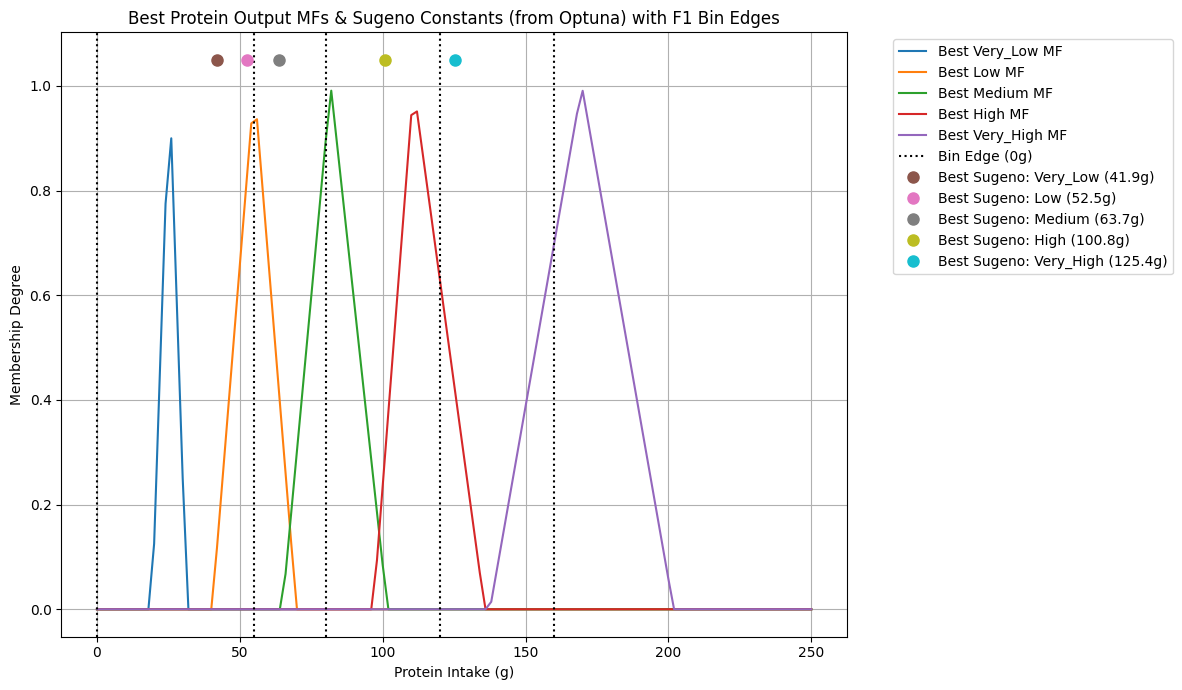

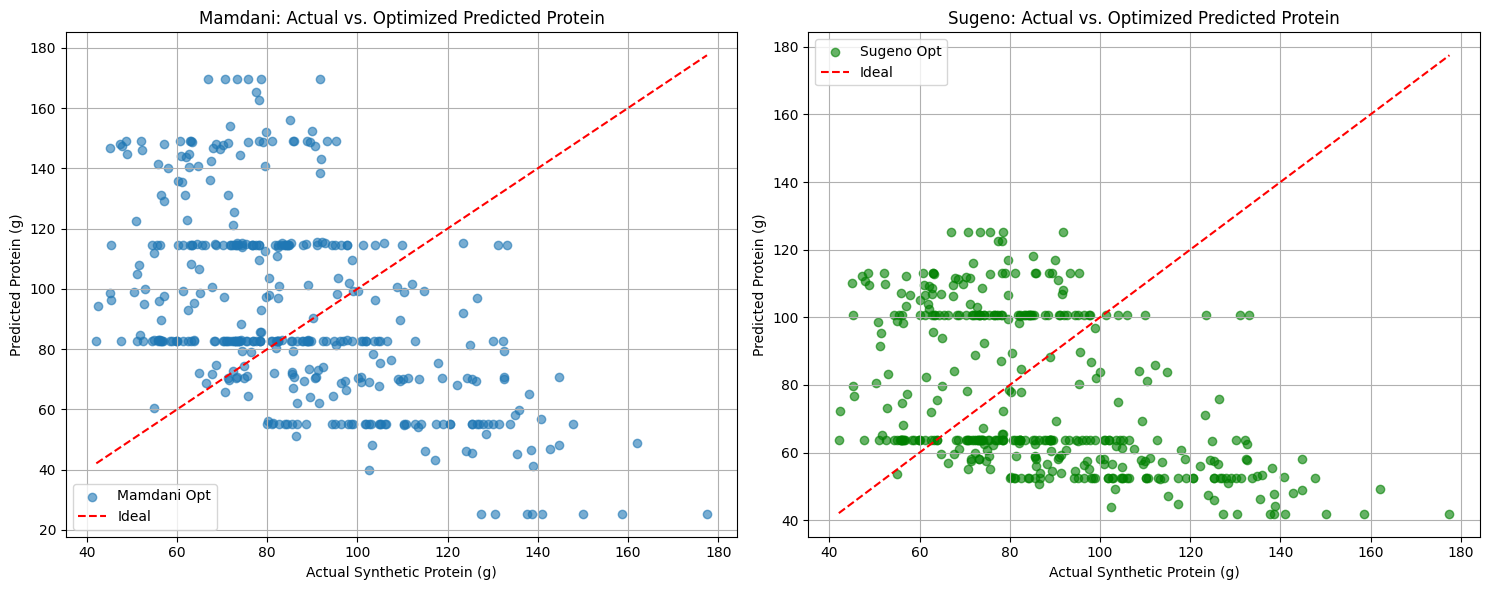


--- Program with Optuna and Final Evaluation End ---


In [28]:
print("\n--- 10. RE-EVALUATE AND PLOT WITH BEST OPTUNA PARAMETERS ---")

if 'study_sugeno' not in globals() or study_sugeno.best_trial is None:
    print("Optuna study has not been run or no best trial found. Skipping final evaluation.")
else:
    best_params = study_sugeno.best_params # Get the best parameters from the study

    # Reconstruct best MF params from Optuna's best_params
    best_protein_mf_params = {
        'Very_Low':  (max(0, best_params['p_vl_peak'] - best_params['p_vl_width']/2), best_params['p_vl_peak'], best_params['p_vl_peak'] + best_params['p_vl_width']/2),
        'Low':       (max(best_params['p_vl_peak'] + best_params['p_vl_width']/2 - 5, best_params['p_l_peak'] - best_params['p_l_width']/2), best_params['p_l_peak'], best_params['p_l_peak'] + best_params['p_l_width']/2),
        'Medium':    (max(best_params['p_l_peak'] + best_params['p_l_width']/2 - 5, best_params['p_m_peak'] - best_params['p_m_width']/2), best_params['p_m_peak'], best_params['p_m_peak'] + best_params['p_m_width']/2),
        'High':      (max(best_params['p_m_peak'] + best_params['p_m_width']/2 - 5, best_params['p_h_peak'] - best_params['p_h_width']/2), best_params['p_h_peak'], best_params['p_h_peak'] + best_params['p_h_width']/2),
        'Very_High': (max(best_params['p_h_peak'] + best_params['p_h_width']/2 - 5, best_params['p_vh_peak'] - best_params['p_vh_width']/2), best_params['p_vh_peak'], best_params['p_vh_peak'] + best_params['p_vh_width']/2)
    }
    best_sugeno_constants = {
        'Very_Low': best_params['s_vl'], 'Low': best_params['s_l'], 'Medium': best_params['s_m'],
        'High': best_params['s_h'], 'Very_High': best_params['s_vh']
    }

    # Dynamically define the best protein MFs
    best_protein_terms_map = {}
    for term, params_mf in best_protein_mf_params.items(): # renamed params to params_mf
        best_protein_terms_map[term] = create_triangular_mf_opt(*params_mf)

    # --- Defuzzification Functions with BEST trial's parameters ---
    def defuzzify_mamdani_best_final(aggregated_strengths):
        aggregated_output_curve = np.zeros_like(protein_domain_samples_opt, dtype=float)
        for z_idx, z_val in enumerate(protein_domain_samples_opt):
            max_membership_at_z = 0.0
            for protein_term, strength in aggregated_strengths.items():
                if strength > 0:
                    term_mf_value = best_protein_terms_map[protein_term](z_val) # Use best_protein_terms_map
                    max_membership_at_z = max(max_membership_at_z, min(term_mf_value, strength))
            aggregated_output_curve[z_idx] = max_membership_at_z
        if np.sum(aggregated_output_curve) == 0: return 0
        num = np.sum(protein_domain_samples_opt * aggregated_output_curve)
        den = np.sum(aggregated_output_curve)
        return num / den if den != 0 else 0

    def defuzzify_sugeno_best_final(rule_strengths_per_consequence):
        num = 0; den = 0
        for term, strength in rule_strengths_per_consequence.items():
            num += strength * best_sugeno_constants[term] # Use best_sugeno_constants
            den += strength
        return num / den if den != 0 else 0

    # --- Generate Predictions with Best Parameters ---
    final_mamdani_preds = []
    final_sugeno_preds = []

    if bmi_df_for_opt.empty:
        print("bmi_df_for_opt is empty. Cannot generate final predictions.")
    else:
        for _, row in bmi_df_for_opt.iterrows():
            f_bmi, f_bf = fuzzify_inputs_opt(row['BMI'], row['BodyFat'], row['Sex'])
            agg_strengths = apply_rules_mamdani_opt(f_bmi, f_bf, rules)

            mam_pred = defuzzify_mamdani_best_final(agg_strengths)
            final_mamdani_preds.append(mam_pred)
            
            sug_pred = defuzzify_sugeno_best_final(agg_strengths)
            final_sugeno_preds.append(sug_pred)

        bmi_df_for_opt['Protein_Mamdani_Opt'] = final_mamdani_preds
        bmi_df_for_opt['Protein_Sugeno_Opt'] = final_sugeno_preds

        # --- Calculate Final Metrics (F1 and Accuracy) ---
        actual_binned_final = pd.cut(bmi_df_for_opt['Protein'], bins=protein_bins_edges_opt, labels=False, include_lowest=True, duplicates='drop')
        
        mamdani_binned_final = pd.cut(bmi_df_for_opt['Protein_Mamdani_Opt'], bins=protein_bins_edges_opt, labels=False, include_lowest=True, duplicates='drop')
        sugeno_binned_final = pd.cut(bmi_df_for_opt['Protein_Sugeno_Opt'], bins=protein_bins_edges_opt, labels=False, include_lowest=True, duplicates='drop')

        valid_actual_indices_final = actual_binned_final.dropna().index
        
        # Mamdani
        mamdani_pred_valid_final = mamdani_binned_final.loc[valid_actual_indices_final].dropna()
        actual_for_mamdani_final = actual_binned_final.loc[mamdani_pred_valid_final.index]
        
        # Sugeno
        sugeno_pred_valid_final = sugeno_binned_final.loc[valid_actual_indices_final].dropna()
        actual_for_sugeno_final = actual_binned_final.loc[sugeno_pred_valid_final.index]

        print("\n--- Final Performance Metrics with Best Optuna Parameters ---")
        if not actual_for_mamdani_final.empty and not mamdani_pred_valid_final.empty and len(actual_for_mamdani_final) == len(mamdani_pred_valid_final):
            if len(np.unique(actual_for_mamdani_final)) > 1 and len(np.unique(mamdani_pred_valid_final)) > 1:
                f1_mamdani_best = f1_score(actual_for_mamdani_final, mamdani_pred_valid_final, average='macro', zero_division=0)
                acc_mamdani_best = accuracy_score(actual_for_mamdani_final, mamdani_pred_valid_final)
                print(f"Best Params - Mamdani Accuracy: {acc_mamdani_best*100:.2f}%, F1 Score: {f1_mamdani_best:.4f}")
                print("\nMamdani Classification Report (Best Params):")
                print(classification_report(actual_for_mamdani_final, mamdani_pred_valid_final, zero_division=0, labels=np.unique(mamdani_pred_valid_final))) # Added labels for clarity
            else:
                print("Mamdani: Not enough classes to compute F1/Accuracy robustly.")
        else:
            print("Could not calculate Mamdani final metrics: Data alignment issue or empty binned data.")

        if not actual_for_sugeno_final.empty and not sugeno_pred_valid_final.empty and len(actual_for_sugeno_final) == len(sugeno_pred_valid_final):
            if len(np.unique(actual_for_sugeno_final)) > 1 and len(np.unique(sugeno_pred_valid_final)) > 1:
                f1_sugeno_best = f1_score(actual_for_sugeno_final, sugeno_pred_valid_final, average='macro', zero_division=0)
                acc_sugeno_best = accuracy_score(actual_for_sugeno_final, sugeno_pred_valid_final)
                print(f"Best Params - Sugeno Accuracy: {acc_sugeno_best*100:.2f}%, F1 Score: {f1_sugeno_best:.4f}")
                print("\nSugeno Classification Report (Best Params):")
                print(classification_report(actual_for_sugeno_final, sugeno_pred_valid_final, zero_division=0, labels=np.unique(sugeno_pred_valid_final))) # Added labels
            else:
                print("Sugeno: Not enough classes to compute F1/Accuracy robustly.")
        else:
            print("Could not calculate Sugeno final metrics: Data alignment issue or empty binned data.")


        # --- Plot the Best MFs found by Optuna ---
        plt.figure(figsize=(12, 7))
        for term, mf_func in best_protein_terms_map.items(): # Use best_protein_terms_map
            plt.plot(protein_domain_samples_opt, [mf_func(x) for x in protein_domain_samples_opt], label=f'Best {term} MF')
        for edge in protein_bins_edges_opt:
            plt.axvline(edge, color='k', linestyle=':', linewidth=1.5, label=f'Bin Edge ({edge}g)' if edge == protein_bins_edges_opt[0] else None)
        # Also plot best Sugeno constants
        for term, const_val in best_sugeno_constants.items():
            plt.plot(const_val, 1.05, marker='o', markersize=8, label=f'Best Sugeno: {term} ({const_val:.1f}g)', linestyle='None')
        plt.title('Best Protein Output MFs & Sugeno Constants (from Optuna) with F1 Bin Edges')
        plt.xlabel('Protein Intake (g)'); plt.ylabel('Membership Degree'); plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.grid(True); plt.tight_layout(); plt.show()


        # --- Final Scatter Plots ---
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(bmi_df_for_opt['Protein'], bmi_df_for_opt['Protein_Mamdani_Opt'], alpha=0.6, label='Mamdani Opt')
        plt.plot([bmi_df_for_opt['Protein'].min(), bmi_df_for_opt['Protein'].max()], [bmi_df_for_opt['Protein'].min(), bmi_df_for_opt['Protein'].max()], 'r--', label='Ideal')
        plt.title('Mamdani: Actual vs. Optimized Predicted Protein')
        plt.xlabel('Actual Synthetic Protein (g)'); plt.ylabel('Predicted Protein (g)'); plt.legend(); plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.scatter(bmi_df_for_opt['Protein'], bmi_df_for_opt['Protein_Sugeno_Opt'], alpha=0.6, color='green', label='Sugeno Opt')
        plt.plot([bmi_df_for_opt['Protein'].min(), bmi_df_for_opt['Protein'].max()], [bmi_df_for_opt['Protein'].min(), bmi_df_for_opt['Protein'].max()], 'r--', label='Ideal')
        plt.title('Sugeno: Actual vs. Optimized Predicted Protein')
        plt.xlabel('Actual Synthetic Protein (g)'); plt.ylabel('Predicted Protein (g)'); plt.legend(); plt.grid(True)
        plt.tight_layout()
        plt.show()

print("\n--- Program with Optuna and Final Evaluation End ---")